In [47]:
from glob import glob
import baltic as bt
from matplotlib import pyplot as plt
%matplotlib inline
import random
import pickle

In [84]:
treefiles = glob('/Users/Sidney/Dropbox/siv/beast/discreteTraits/h24/asymmetric/trees/mcc/*.mcc')
treefiles.sort(key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[1]))

trees = { i:bt.loadNexus(treefile, absoluteTime=False) for i,treefile in enumerate(treefiles)}

strain_names = pickle.load(open('/Users/Sidney/Dropbox/siv/figures/strain_names.p', 'rb'))
common_names = pickle.load(open('/Users/Sidney/Dropbox/siv/figures/common_names.p', 'rb'))
sizes = pickle.load(open('/Users/Sidney/Dropbox/siv/figures/sizes.p', 'rb'))
colors = pickle.load(open('/Users/Sidney/Dropbox/siv/figures/colors.p', 'rb'))


Tree height: 1.971960
Tree length: 32.214263

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 287 (143 nodes and 144 leaves)


Tree height: 1.169393
Tree length: 24.343463

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 279 (139 nodes and 140 leaves)


Tree height: 1.190811
Tree length: 31.401857

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 223 (111 nodes and 112 leaves)


Tree height: 0.763652
Tree length: 23.981727

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 231 (115 nodes and 116 leaves)


Tree height: 1.039476
Tree length: 36.547966

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 453 (226 nodes and 227 leaves)



In [87]:
for gene, tree in trees.items():
    for n in sorted(tree.nodes,key=lambda x: -x.height):
        if n.parent.index =='Root' or is_monophyletic(n.parent, 'host'):
            continue
        elif is_monophyletic(n, 'host'):
            try:
                strain = strainName( [ k.name for k in n.children if isinstance(k, bt.leaf) ][0] )
                new_name = '%s_%d'%(strain, random.randint(500,1000))
            except:
                new_name = '%d'%(random.randint(500,1000))
            tree.collapse(n, new_name)
    tree.drawTree()

In [88]:
def is_monophyletic(node, trait):
    n_states = len(set([k.traits[trait] for k in tree.traverse_tree(node, include_all=True) if isinstance(k, bt.leaf)]))
    if n_states == 1:
        return True
    else:
        return False

def strainName(taxaName):
    strain = taxaName.split('|')[4].lower()
    if strain.startswith('H'):
        return 'HIV-%s'%strain[1]
    else:
        return 'SIV'+taxaName.split('|')[4].lower()    
        
def desaturate(color, s): # Adjust (R,G,B,A) tuple by saturation proportion s
    if s > 0.85:
        return color
    else:
        i = [ float(c)*(float(s)) for c in color[:3]]
        i.append(s)
    return tuple(i)
        
def plot_tree(cur_tree, ax, ID):
    branchWidth = 5
    maxW = []
    maxX,maxY = 0.0, 0.0
    for t in trees.values():
        maxW += [ k.width for k in t.Objects if isinstance(k,bt.clade) ]
    if maxW != []:
        maxW = float(max(maxW))

    for k in cur_tree.Objects: ## iterate over branches
        label = strain_names[k.traits['host']]

        x=k.height ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
        xp=k.parent.height ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x    
        maxX = max(x, maxX)
        maxY = max(y, maxY)

        if k.traits.has_key('host') and k.traits.has_key('host.prob'):
            c_desat=desaturate(colors[k.traits['host']], k.traits['host.prob']) ## can be discrete too
            c = colors[k.traits['host']]
        else:
            c, c_desat='k', 'k'
        if k.branchType=='leaf': ## if leaf...
            s=80 ## tip size can be fixed
            ax.text(cur_tree.treeHeight+0.05,y,label, size=14)
            if isinstance(k, bt.clade):
                left, right = x, cur_tree.treeHeight
                width = max(k.width / maxW, 0.06)

                points = [[left, y], [right,y+0.5*width], [right,y-0.5*width]]
                ax.add_patch(plt.Polygon(points, facecolor=c, zorder=8, edgecolor=None) )

            else:
                ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.7*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node): ## if node...
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c_desat,ls='-',zorder=9) ## plot vertical bar

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c_desat,ls='-',zorder=9) ## always plot branch
    ax.text(0.0, 0.0, '%d'%ID, fontsize=48)
#     ax.plot([0.0,0.5],[-0.8,-0.8], lw=branchWidth, color='gray', ls='-')
#     ax.text(0.0, -1.2, '0.5 subs/site', fontsize=44)

    ax.set_ylim(-1.0,maxY+1.0) ## set y limits
    ax.set_xlim(0.0, maxX+1.0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',labelsize=0,size=0)
    ax.tick_params(axis='y',labelsize=0,size=0)

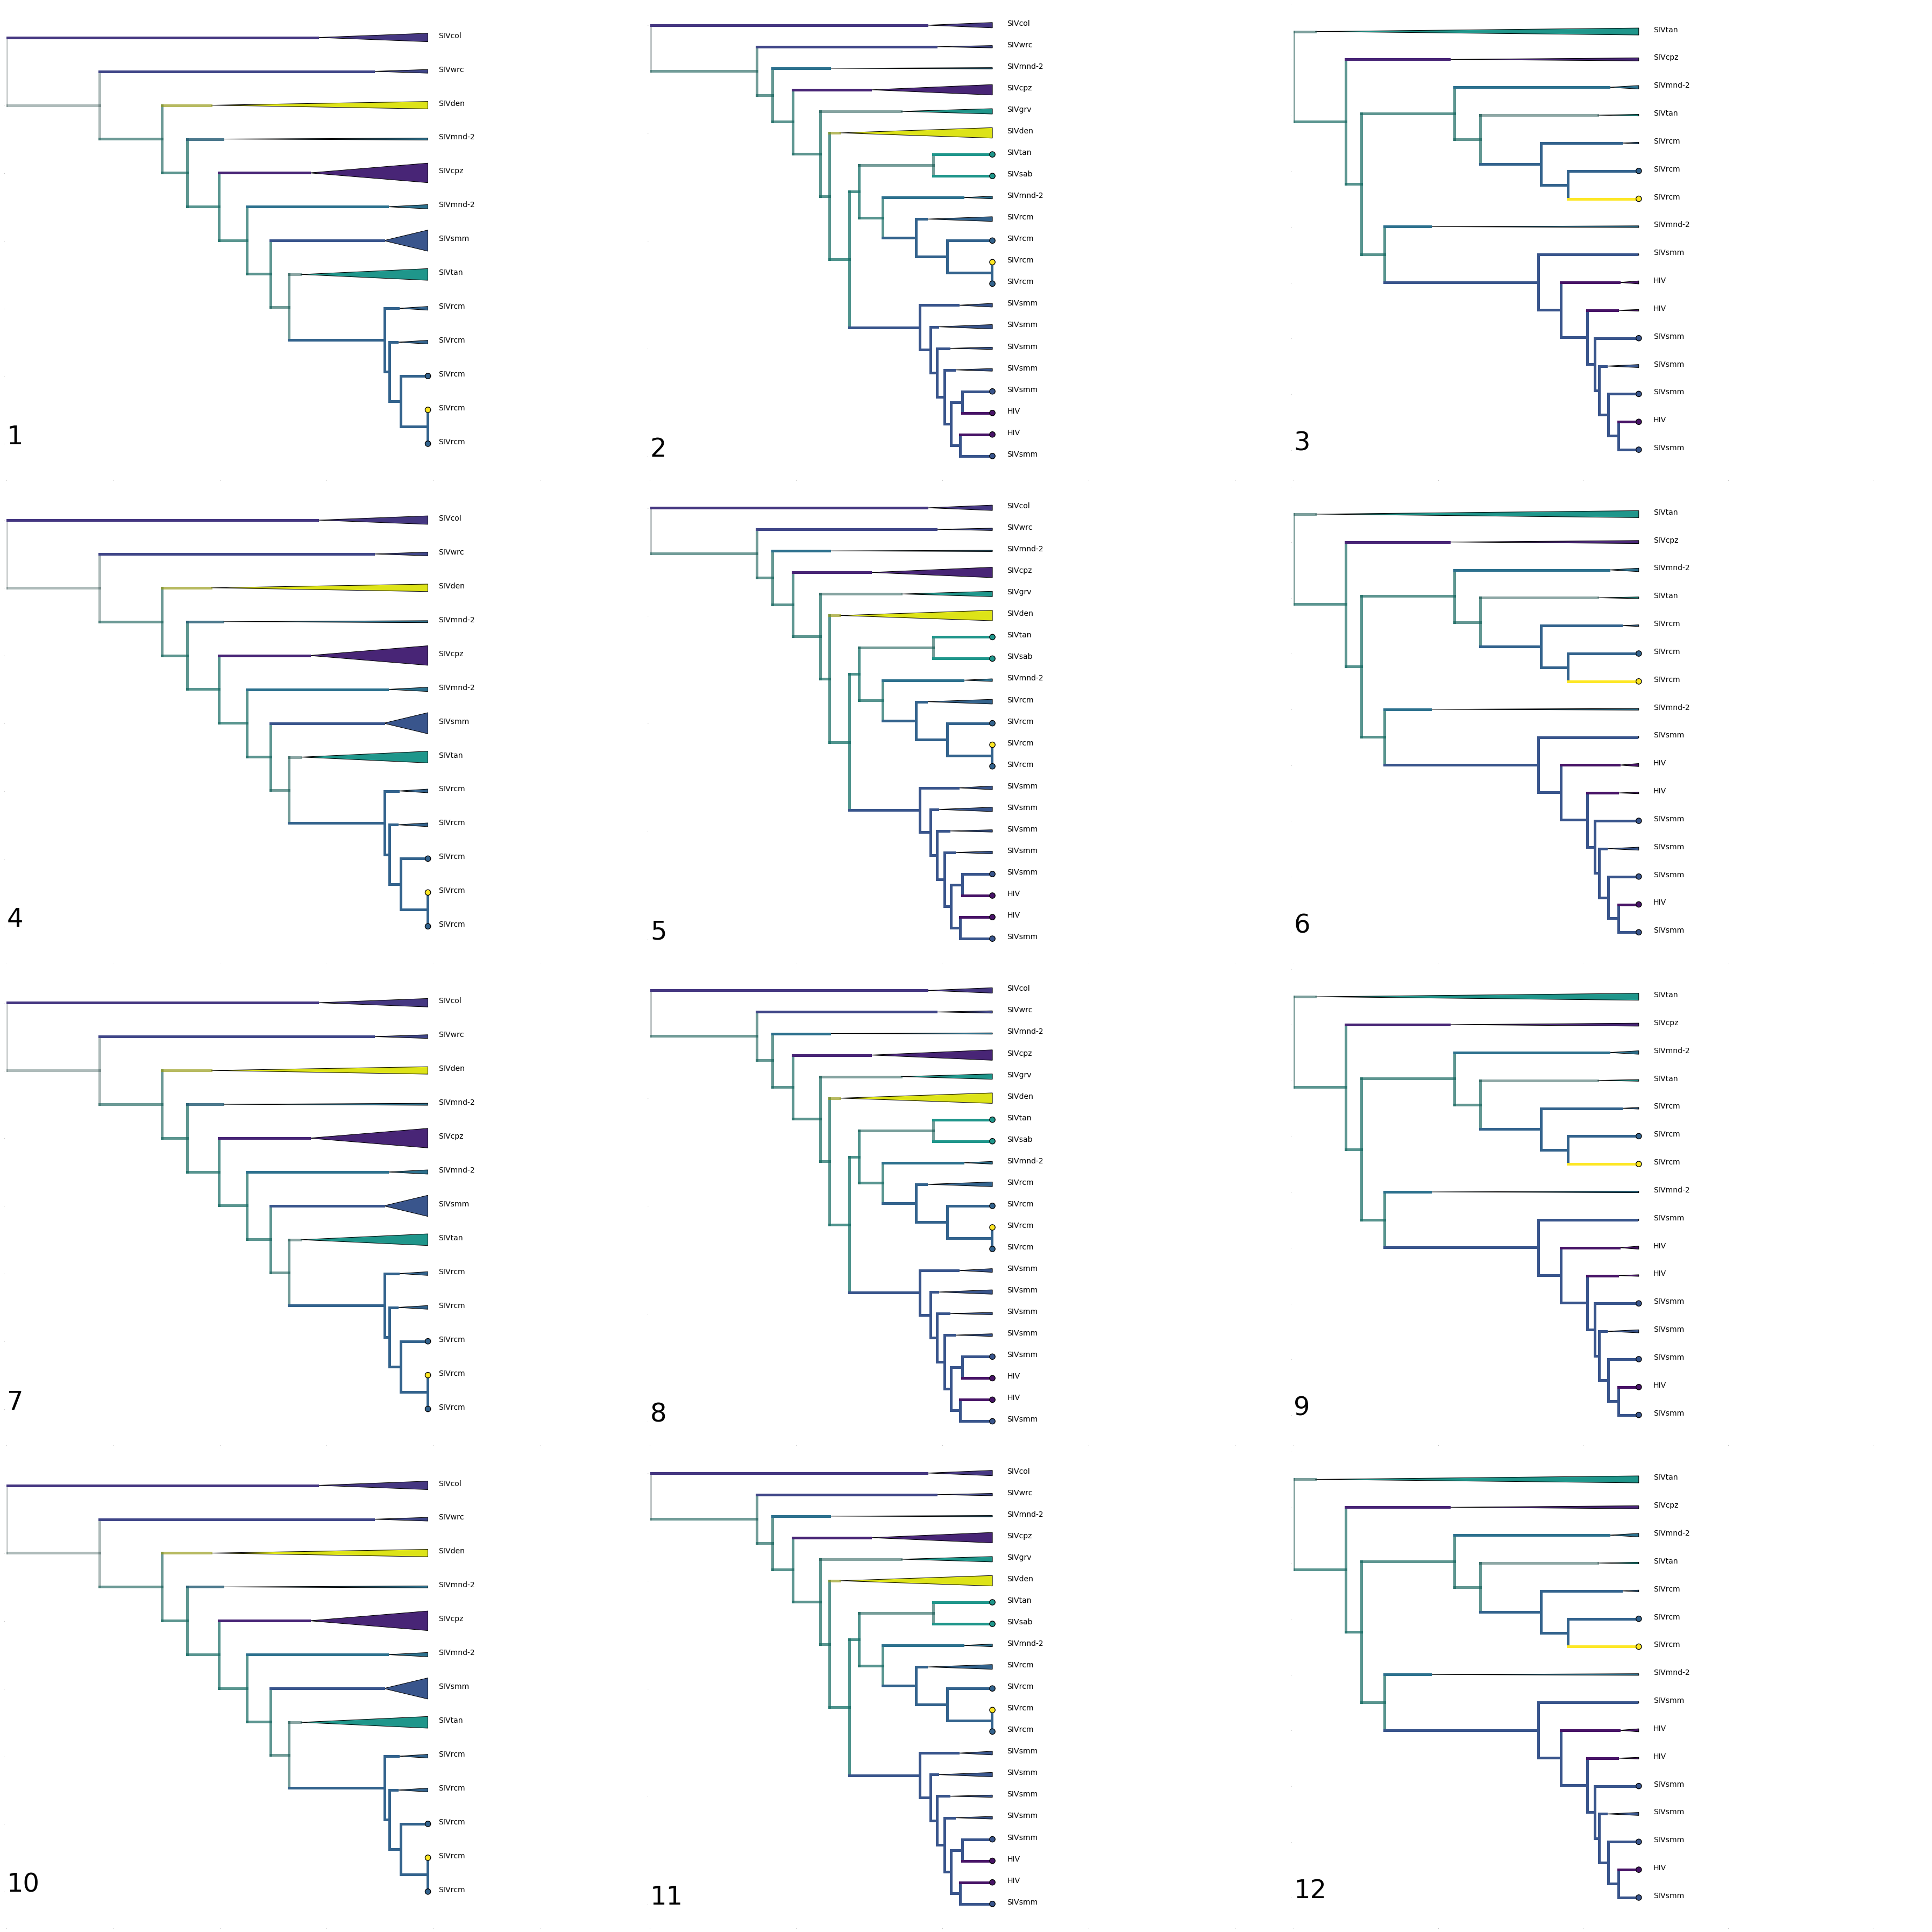

In [89]:
fig, axes = plt.subplots(4,3, figsize=(50,50))

treelist = [ trees[i] for i in range(len(trees)) ]
segmentNumber = 1

for row in axes:
    for treeObject, axis in zip(treelist, row):
        axis=plot_tree(treeObject, axis, segmentNumber)
        segmentNumber += 1
plt.tight_layout()
plt.show()
